### Library Setup, Data loading and inspection

After loading the data, I analyzed the data structure and types to manage it properly. Specifically, I converted the 'Longitudin' and 'Latitudine' columns from objects to floats.
(I’ve included comments in the code to explain how I checked the data types.)

In [13]:
#%% Import libraries 
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load the GeoPackage file
file_path = "resa_girasole_2022.gpkg"
data = gpd.read_file(file_path)

print(f' Dataset of shape {data.shape} with the following structure: \n\n{data.head()}\n\n')
print(f" Columns' datatypes: \n\n{data.dtypes}\n\n")

# since we have objects in the dataset, print the specific object's type
print(type(data["Data/Ora"]))
print(type(data["Longitudin"]))
print(type(data["Latitudine"]))
print(type(data["geometry"]))

# Replace commas with dots and convert to float
data['Longitudin'] = data['Longitudin'].str.replace(',', '.').astype(float)
data['Latitudine'] = data['Latitudine'].str.replace(',', '.').astype(float)

# Verify the conversion
print(data.dtypes)

 Dataset of shape (1962, 8) with the following structure: 

               Data/Ora  Longitudin  Latitudine  RESAKG  VELOCITA     AREA  \
0  5 set 2022, 10:08:09  11,9758245  44,8474908  1870.0      4.80  140.000   
1  5 set 2022, 10:08:24  11,9758157  44,8476751  1270.0      4.83  140.875   
2  5 set 2022, 10:08:40  11,9758154  44,8478795  1420.0      4.78  139.417   
3  5 set 2022, 10:08:55  11,9758209  44,8480593  2010.0      4.85  141.458   
4  5 set 2022, 10:09:10  11,9758201  44,8482443  1320.0      4.80  140.000   

   UMIDITA                         geometry  
0      NaN  POINT (1333142.685 5597543.903)  
1      NaN  POINT (1333141.706 5597572.841)  
2      NaN  POINT (1333141.672 5597604.934)  
3     33.1  POINT (1333142.284 5597633.165)  
4     33.1  POINT (1333142.195 5597662.213)  


 Columns' datatypes: 

Data/Ora        object
Longitudin      object
Latitudine      object
RESAKG         float64
VELOCITA       float64
AREA           float64
UMIDITA        float64
geometry 

---

First, I wanted to determine if 'Longitudin', 'Latitudine', and 'geometry' carried the same information. To verify this, I visualized these values using Matplotlib.

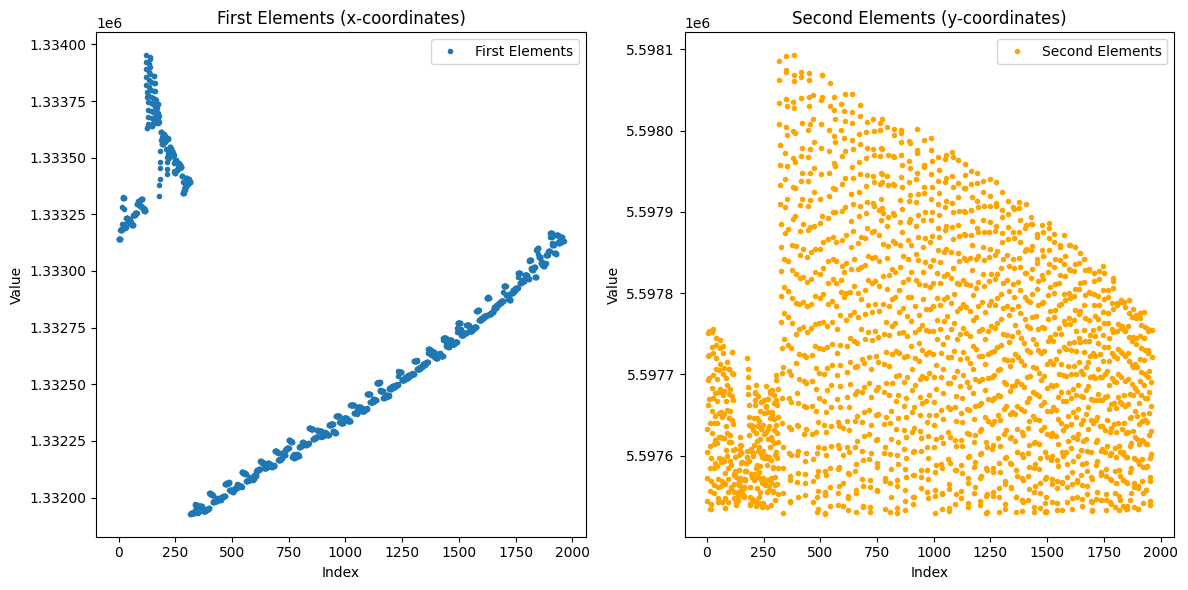

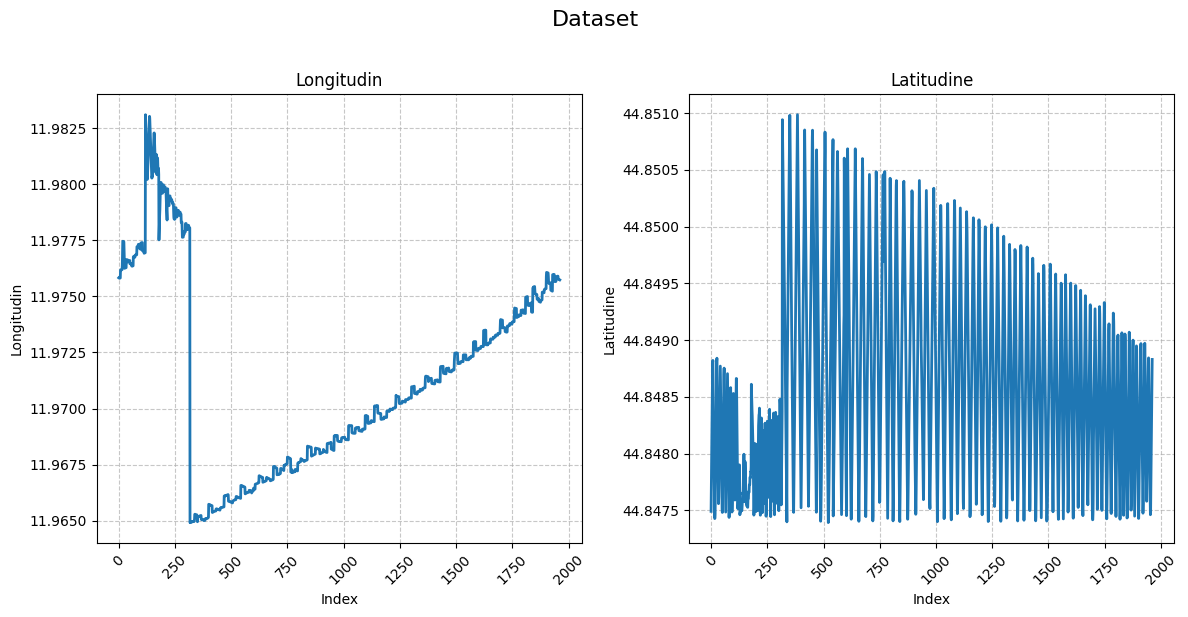

In [14]:
# estract and compare geometry data with latitudine and logitudine for understanding if they are effectively the same
# the 'geometry' column of the dataset stores Point (class 'shapely.geometry.point.Point')
# I extract and store each point in a python list of float tuples
geometry = [(point.x, point.y) for point in data["geometry"]]

# plot for seeing similarities/differences
# Extract the first and second elements of the tuples
x_coords = [t[0] for t in geometry]  # First elements (e.g., x-coordinates)
y_coords = [t[1] for t in geometry]  # Second elements (e.g., y-coordinates)
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot first elements in the first subplot
axs[0].plot(x_coords, marker='o', linestyle='', markersize=3, label='First Elements')
axs[0].set_title('First Elements (x-coordinates)')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')
axs[0].legend()
# Plot second elements in the second subplot
axs[1].plot(y_coords, marker='o', linestyle='', markersize=3, color='orange', label='Second Elements')
axs[1].set_title('Second Elements (y-coordinates)')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')
axs[1].legend()
# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Define the columns to plot
columns_to_plot = ["Longitudin", "Latitudine"]

# Create figure and subplots (2 rows, 3 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Dataset', fontsize=16, y=1.02)
# Flatten axes array for easier iteration
axes_flat = axes.flatten()
# Plot each column in a separate subplot
for idx, col_name in enumerate(columns_to_plot):
    ax = axes_flat[idx]
    # Create the line plot
    ax.plot(data[col_name], linewidth=2)
    # Customize the subplot
    ax.set_title(col_name)
    ax.set_xlabel('Index')
    ax.grid(True, linestyle='--', alpha=0.7)
    # Add y-axis label
    ax.set_ylabel(col_name)
    # Rotate x-axis labels if needed
    ax.tick_params(axis='x', rotation=45)
# Adjust layout to prevent overlapping
plt.tight_layout()
# Show the plot
plt.show()

---


Once I ensured the dataset's integrity, I performed a comprehensive check for missing values (NaN/NULL). Since only the 'UMIDITA' column contains missing values, I focused on filling those.

Next, I created a validation function to check and clean the dataset, ensuring data quality and consistency. The validation process includes the following main steps:

- Longitude values must be within the range [-180, 180].
- Latitude values must be within the range [-90, 90].
- RESAKG (Harvested Product Amount) must be positive.
- VELOCITA (Harvester Speed) must be within [0, 20] km/h.
- AREA (Harvested Area) must be within [0, 5000] square meters.
- UMIDITA (Relative Humidity) must be within the [0, 100]% range.
- Duplicate rows are identified, reported, and removed.

Finally, I normalized all variables to a 0–1 range for comparative analysis.


In [15]:
# Missing values 
print("Number of NaN/NULL values in all columns:")
print(data.isnull().sum())

# Since only the 'UMIDITA' column has missing values, we can fill only that column
# Replace NaN values with:
# 0 -> data['UMIDITA'] = data['UMIDITA'].fillna(0)
# medians -> data['UMIDITA'] = data['UMIDITA'].fillna(data['UMIDITA'].median())
# linear interpolation -> data['UMIDITA'] = data['UMIDITA'].fillna(data['UMIDITA'].interpolate(method='linear'))

# means:
data['UMIDITA'] = data['UMIDITA'].fillna(data['UMIDITA'].mean())

print("Number of NaN/NULL values in all columns after filling missing values:")
print(data.isnull().sum())


#%% Function for validating data and cleaning anomalies

def validate_and_clean_data(data):
    try:
        # Validate Georeferences
        if not ((data["Longitudin"].between(-180, 180)).all() and (data["Latitudine"].between(-90, 90)).all()):
            invalid_rows = data[~((data["Longitudin"].between(-180, 180)) & (data["Latitudine"].between(-90, 90)))]
            raise ValueError(f"Invalid georeference rows found:\n{invalid_rows}")

        # Detect and Remove Duplicates
        if data.duplicated().any():
            duplicates = data[data.duplicated()]
            raise ValueError(f"Duplicate rows found:\n{duplicates}")

        # Remove duplicates
        data = data.drop_duplicates()

        # Handle Anomalous Values
        anomalies = {}

        # Check RESAKG (Harvested Product Amount)
        if (data["RESAKG"] < 0).any():
            anomalies["RESAKG"] = data[data["RESAKG"] < 0]
            data.loc[data["RESAKG"] < 0, "RESAKG"] = 0  # Replace negatives with 0 (capping)

        # Check VELOCITA (Speed of Harvester)
        if (~data["VELOCITA"].between(0, 20)).any():
            anomalies["VELOCITA"] = data[~data["VELOCITA"].between(0, 20)]
            data.loc[data["VELOCITA"] < 0, "VELOCITA"] = 0  # Replace negatives with 0
            data.loc[data["VELOCITA"] > 20, "VELOCITA"] = 20  # Cap at 20 km/h

        # Check AREA (Harvested Area)
        if (data["AREA"] <= 0).any() or (data["AREA"] > 5000).any():  # Assuming 5000 sqm is a realistic upper limit
            anomalies["AREA"] = data[(data["AREA"] <= 0) | (data["AREA"] > 5000)]
            data.loc[data["AREA"] <= 0, "AREA"] = 1  # Replace non-positive values with a minimum
            data.loc[data["AREA"] > 5000, "AREA"] = 5000  # Cap at 5000 sqm

        # Check UMIDITA (Relative Humidity)
        if (~data["UMIDITA"].between(0, 100)).any():
            anomalies["UMIDITA"] = data[~data["UMIDITA"].between(0, 100)]
            data.loc[data["UMIDITA"] < 0, "UMIDITA"] = 0  # Replace negatives with 0
            data.loc[data["UMIDITA"] > 100, "UMIDITA"] = 100  # Cap at 100%

        # Report anomalies if any
        if anomalies:
            print("Anomalies found:")
            for column, rows in anomalies.items():
                print(f"\n{column} anomalies:")
                print(rows)
        else:
            print("No anomalies detected. Rows removed: 0")

        return data

    except ValueError as e:
        print(e)
        return None

# Validate and clean the data
cleaned_data = validate_and_clean_data(data)

# Define the columns to plot (in this case are the columns we're interested in)
columns_to_plot = ["Longitudin", "Latitudine", "RESAKG", "VELOCITA", "AREA", "UMIDITA"]
# Normalize each column to a 0-1 range
data[columns_to_plot] = (data[columns_to_plot] - data[columns_to_plot].min()) / \
                                   (data[columns_to_plot].max() - data[columns_to_plot].min())

Number of NaN/NULL values in all columns:
Data/Ora       0
Longitudin     0
Latitudine     0
RESAKG         0
VELOCITA       0
AREA           0
UMIDITA       37
geometry       0
dtype: int64
Number of NaN/NULL values in all columns after filling missing values:
Data/Ora      0
Longitudin    0
Latitudine    0
RESAKG        0
VELOCITA      0
AREA          0
UMIDITA       0
geometry      0
dtype: int64
No anomalies detected. Rows removed: 0


---

To verify the processed dataset, I plotted its values for a final check.

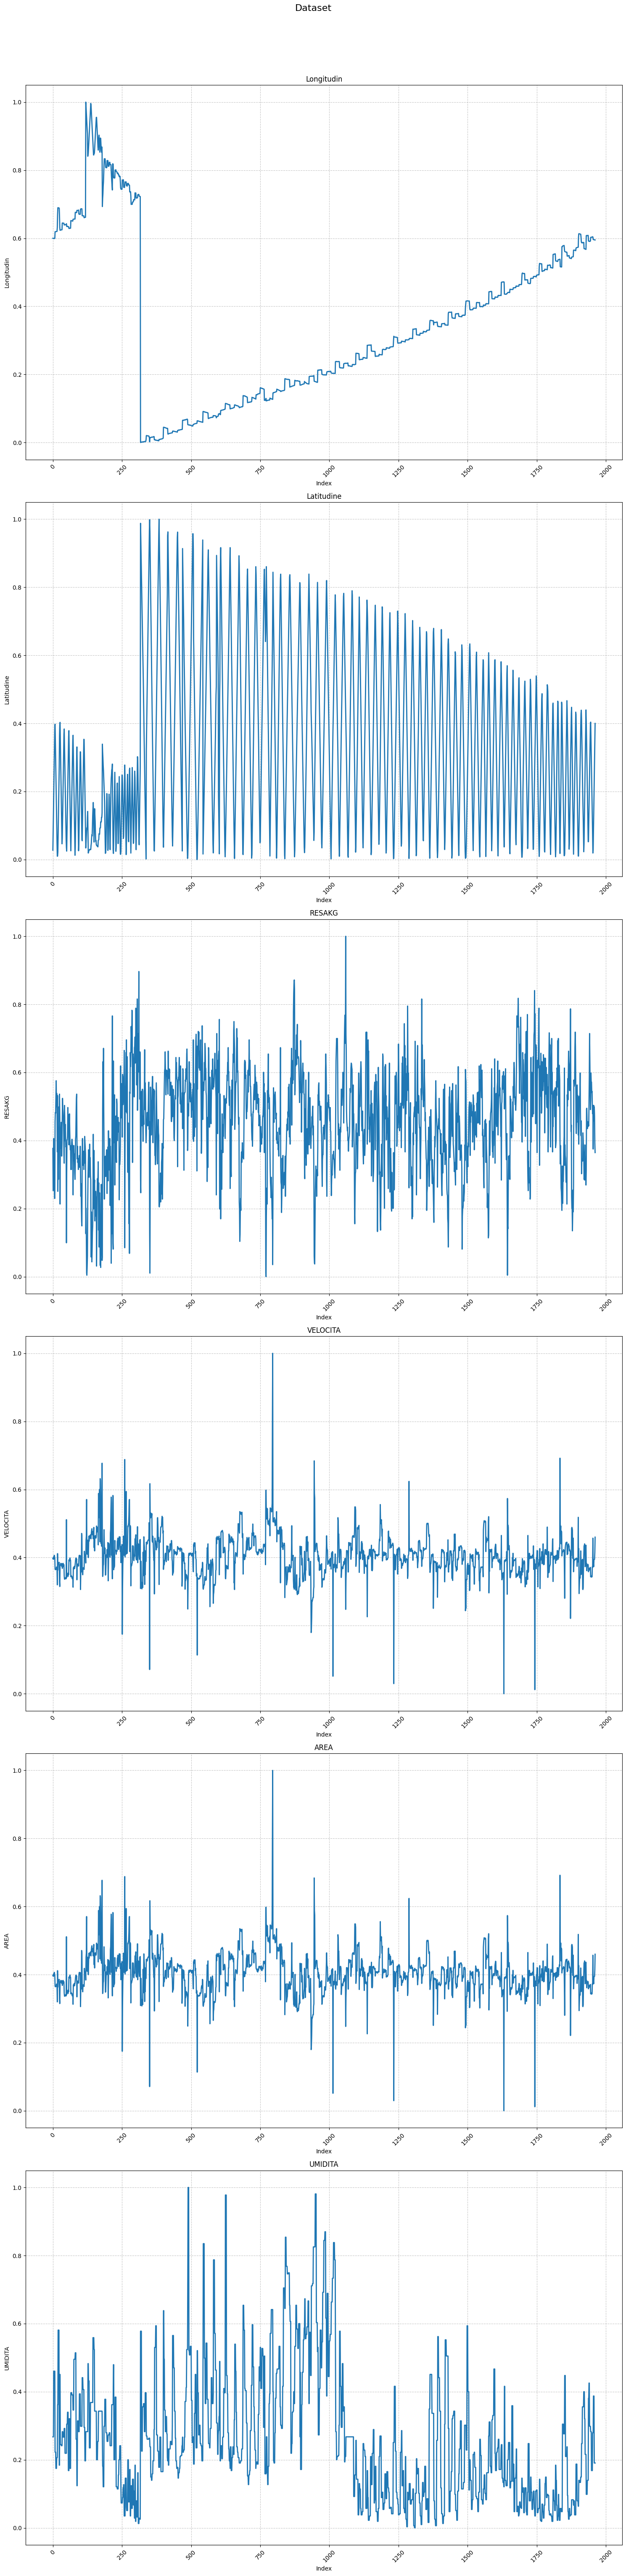

In [16]:


# Define the columns to plot
columns_to_plot = ["Longitudin", "Latitudine", "RESAKG", "VELOCITA", "AREA", "UMIDITA"]

# Create figure and subplots (2 rows, 3 columns)
fig, axes = plt.subplots(6, 1, figsize=(15, 60))
fig.suptitle('Dataset', fontsize=16, y=1.02)

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

# Plot each column in a separate subplot
for idx, col_name in enumerate(columns_to_plot):
    ax = axes_flat[idx]
    
    # Create the line plot
    ax.plot(data[col_name], linewidth=2)
    
    # Customize the subplot
    ax.set_title(col_name)
    ax.set_xlabel('Index')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add y-axis label
    ax.set_ylabel(col_name)
    
    # Rotate x-axis labels if needed
    ax.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


### Interpolation Techniques

Since I am not an expert in interpolation methods, I implemented multiple strategies to create a continuous surface of yield values from the discrete sampling points:

- **Inverse Distance Weighting (IDW)**: Assumes that the value at an unknown point is primarily influenced by nearby known points, with influence decreasing as the distance increases.

- **Kriging**: A geostatistical method that accounts for spatial autocorrelation and estimates the uncertainty in the interpolated values.

- **Natural Neighbor Interpolation**: Uses Voronoi diagrams to determine the influence of surrounding data points, where the influence is proportional to the area of the Voronoi cell intersecting the search radius around the unknown point.

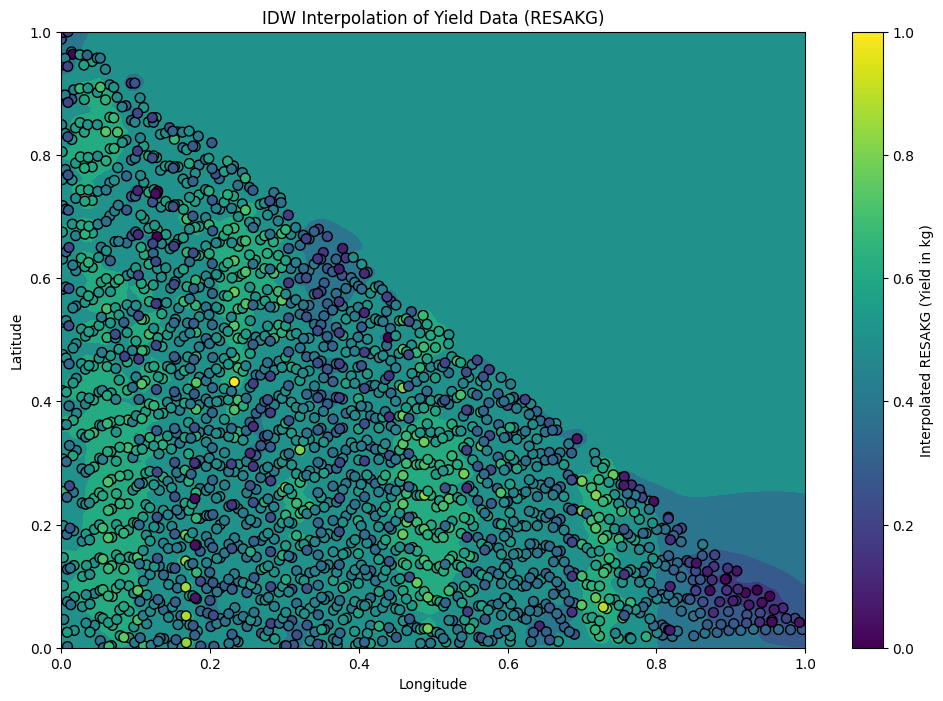

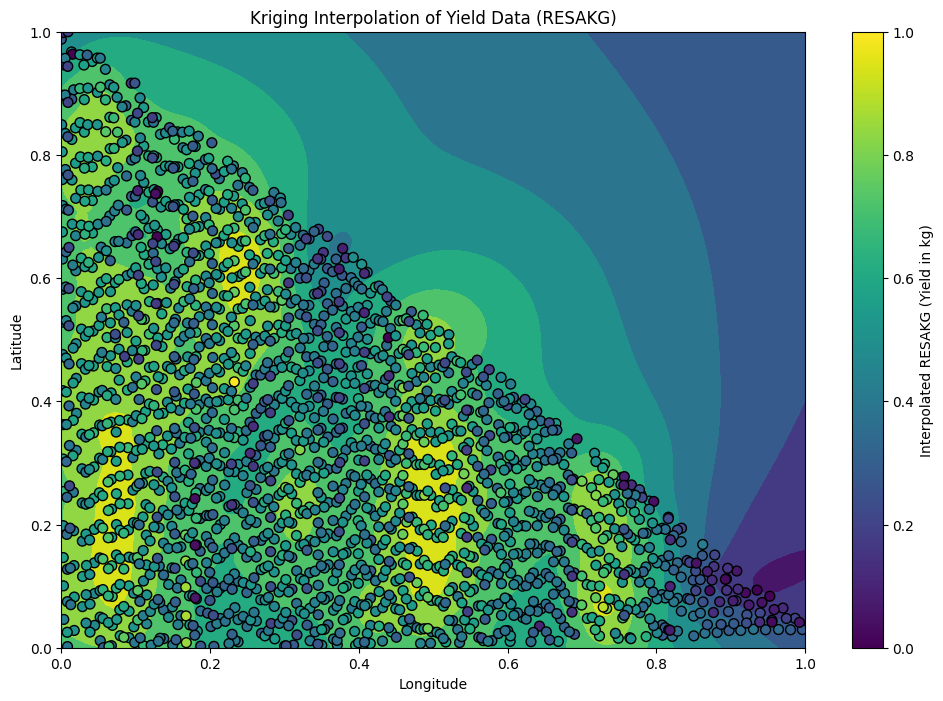

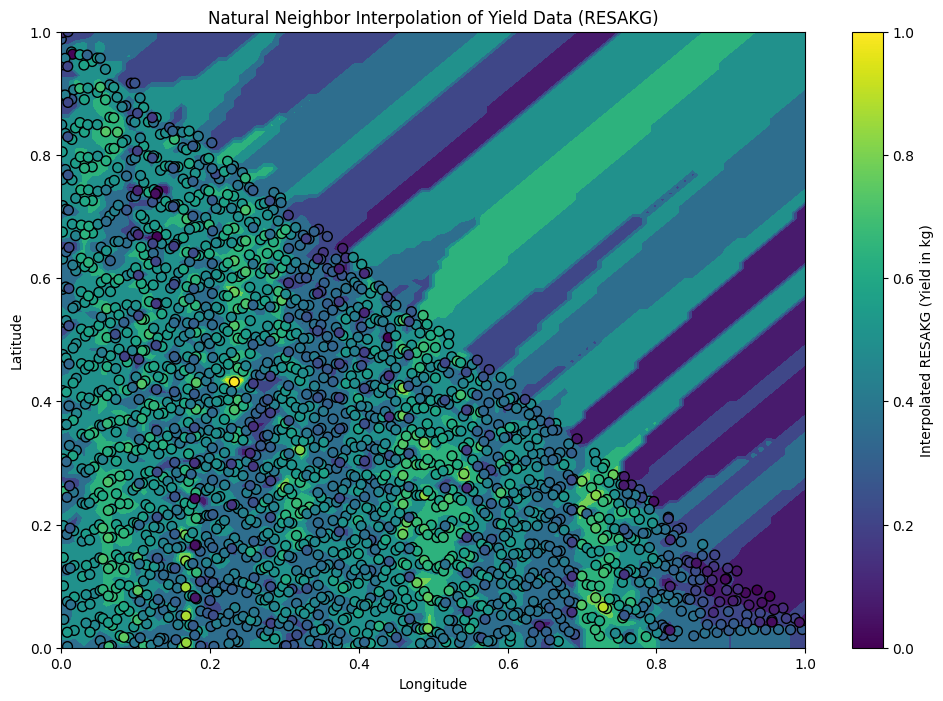

In [17]:
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
from pykrige.ok import OrdinaryKriging
import numpy as np

#IDW interpolation

# Define the power parameter for IDW (common values: 1 to 3)
power = 2
# Grid resolution for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(data["Longitudin"].min(), data["Longitudin"].max(), 100),
    np.linspace(data["Latitudine"].min(), data["Latitudine"].max(), 100)
)
# Function to perform IDW interpolation
def idw_interpolation(x, y, z, grid_x, grid_y, power=2):
    # Create an array of known points
    points = np.array([x, y]).T
    values = np.array(z)
    # Flatten the grid for distance calculations
    grid_points = np.array([grid_x.ravel(), grid_y.ravel()]).T
    # Calculate distances between grid points and known points
    tree = cKDTree(points)
    distances, indices = tree.query(grid_points, k=len(points))
    # Handle distances of zero (set to a small value to avoid division by zero)
    distances[distances == 0] = 1e-10
    # Perform IDW calculation
    weights = 1 / (distances ** power)
    interpolated_values = np.sum(weights * values[indices], axis=1) / np.sum(weights, axis=1)
    # Reshape to grid
    return interpolated_values.reshape(grid_x.shape)
# Perform IDW interpolation for the RESAKG column
interpolated_grid = idw_interpolation(
    data["Longitudin"], data["Latitudine"], data["RESAKG"], grid_x, grid_y, power=power
)
# Plot the interpolated surface
plt.figure(figsize=(12, 8))
plt.contourf(grid_x, grid_y, interpolated_grid, cmap="viridis")
plt.scatter(data["Longitudin"], data["Latitudine"], c=data["RESAKG"], cmap="viridis", edgecolor="k", s=50)
plt.colorbar(label="Interpolated RESAKG (Yield in kg)")
plt.title("IDW Interpolation of Yield Data (RESAKG)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Kriging interpolation

# Grid resolution for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(data["Longitudin"].min(), data["Longitudin"].max(), 100),
    np.linspace(data["Latitudine"].min(), data["Latitudine"].max(), 100)
)
# Function to perform Kriging interpolation
def kriging_interpolation(x, y, z, grid_x, grid_y):
    # Instantiate the Ordinary Kriging model
    OK = OrdinaryKriging(
        x, y, z,
        variogram_model="linear",  # You can experiment with models: "linear", "power", "gaussian", etc.
        verbose=False,
        enable_plotting=False,
    )
    # Perform interpolation over the defined grid
    interpolated_grid, sigma = OK.execute("grid", grid_x[0], grid_y[:, 0])  # Sigma represents error estimates
    return interpolated_grid
# Perform Kriging interpolation for the RESAKG column
interpolated_grid = kriging_interpolation(
    data["Longitudin"].values,
    data["Latitudine"].values,
    data["RESAKG"].values,
    grid_x, grid_y
)
# Plot the interpolated surface
plt.figure(figsize=(12, 8))
plt.contourf(grid_x, grid_y, interpolated_grid, cmap="viridis")
plt.scatter(data["Longitudin"], data["Latitudine"], c=data["RESAKG"], cmap="viridis", edgecolor="k", s=50)
plt.colorbar(label="Interpolated RESAKG (Yield in kg)")
plt.title("Kriging Interpolation of Yield Data (RESAKG)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Natural Neighbor Interpolation

# Grid resolution for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(data["Longitudin"].min(), data["Longitudin"].max(), 100),
    np.linspace(data["Latitudine"].min(), data["Latitudine"].max(), 100)
)
# Function to perform Natural Neighbor Interpolation
def natural_neighbor_interpolation(x, y, z, grid_x, grid_y):
    # Stack the known points into a (n, 2) array
    points = np.array([x, y]).T
    values = np.array(z)
    # Perform Natural Neighbor Interpolation
    interpolated_grid = griddata(points, values, (grid_x, grid_y), method="nearest")
    return interpolated_grid
# Perform Natural Neighbor Interpolation for the RESAKG column
interpolated_grid = natural_neighbor_interpolation(
    data["Longitudin"].values,
    data["Latitudine"].values,
    data["RESAKG"].values,
    grid_x, grid_y
)
# Plot the interpolated surface
plt.figure(figsize=(12, 8))
plt.contourf(grid_x, grid_y, interpolated_grid, cmap="viridis")
plt.scatter(data["Longitudin"], data["Latitudine"], c=data["RESAKG"], cmap="viridis", edgecolor="k", s=50)
plt.colorbar(label="Interpolated RESAKG (Yield in kg)")
plt.title("Natural Neighbor Interpolation of Yield Data (RESAKG)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### Steps for Extracting and Processing NDVI

1. **Go to GEE and Start a New Cloud Project**  
   - Access Google Earth Engine (GEE) and create a new cloud project.

2. **Extract the Edge of the Area**  
   - Extract the edges of the area (a triangle) you want to consider from your dataset using Python.
```python
      # Extract Latitudes and Longitudes
      latitudes = data["Latitudine"].tolist()
      longitudes = data["Longitudin"].tolist()

      # Create a bounding box around the points (optional)
      min_lon, max_lon = min(longitudes), max(longitudes)
      min_lat, max_lat = min(latitudes), max(latitudes)
      bounding_box = Polygon([
         (min_lon, min_lat),
         (max_lon, min_lat),
         (min_lon, max_lat),
         (min_lon, min_lat)  # Close the polygon -> it's a TRIANGLE!
      ])

      # Convert to GeoDataFrame
      gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[bounding_box])

      # Save as a Shapefile
      gdf.to_file("jolanda_di_savoia_plains.shp")
```

3. **Import the Geometry into GEE**  
   - Upload the extracted geometry file (once zipped) into GEE and load it for further processing.
```javascript
      // Load the uploaded geometry
      var studyArea = ee.FeatureCollection("projects/ee-claudiodemaria1999/assets/jolanda_di_savoia_plains");
      // Visualize on the map
      Map.centerObject(studyArea, 12);
      Map.addLayer(studyArea, {}, 'Study Area');
```

4. **Process NDVI in GEE**  
   - For simplicity, calculate NDVI within GEE and export the results as a GeoTIFF file.
```javascript
      // Load Sentinel-2 SR dataset
      var sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR")
      .filterBounds(studyArea) // Filter by study area
      .filterDate('2023-01-01', '2023-12-31') // Filter by date range
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)); // Exclude cloudy images

      // Visualize Sentinel-2 data
      Map.addLayer(sentinel2.median(), {bands: ['B4', 'B3', 'B2'], min: 0, max: 3000}, 'True Color Image');

      // Calculate NDVI for each image
      var addNDVI = function(image) {
      var ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI');
      return image.addBands(ndvi);
      };

      // Apply NDVI calculation to the image collection
      var sentinel2WithNDVI = sentinel2.map(addNDVI);

      // Get the median NDVI over the time range
      var medianNDVI = sentinel2WithNDVI.select('NDVI').median();

      // Clip the NDVI image to your study area
      var clippedNDVI = medianNDVI.clip(studyArea);

      // Visualize the NDVI map
      Map.addLayer(clippedNDVI, {min: 0, max: 1, palette: ['blue', 'white', 'green']}, 'NDVI');

      Export.image.toDrive({
      image: clippedNDVI,
      description: 'NDVI_JolandaDiSavoia',
      scale: 10,
      region: studyArea.geometry().bounds(),
      crs: 'EPSG:4326',
      maxPixels: 1e13
      });
```

5. **Load and Visualize the NDVI GeoTIFF in Python**  
   - Use Python to load the GeoTIFF file and visualize the NDVI data.
```python
      import rasterio
      import matplotlib.pyplot as plt

      # Load the NDVI GeoTIFF
      with rasterio.open("NDVI_JolandaDiSavoia.tif") as src:
         ndvi = src.read(1)
         bounds = src.bounds

      # Visualize NDVI
      plt.imshow(ndvi, cmap="RdYlGn", extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
      plt.colorbar(label="NDVI")
      plt.title("NDVI Map of Jolanda Di Savoia")
      plt.xlabel("Longitude")
      plt.ylabel("Latitude")
      plt.show()
```

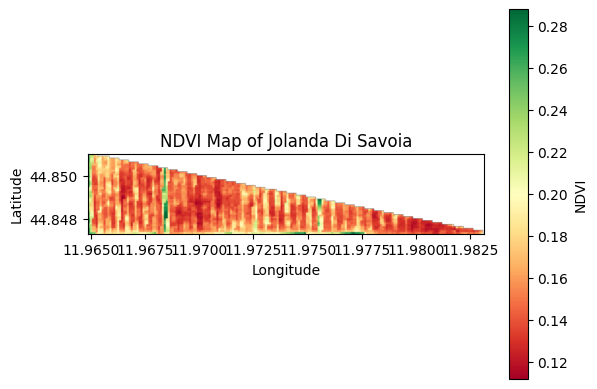

'\nndvi = ndvi[:,:10]\n# the first dimension is the latitude, the second is the longitude\n\n# Visualize NDVI\nplt.imshow(ndvi, cmap="RdYlGn", extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])\nplt.colorbar(label="NDVI")\nplt.title("NDVI Map of Jolanda Di Savoia")\nplt.xlabel("Longitude")\nplt.ylabel("Latitude")\nplt.show()\n'

In [20]:
import rasterio
import matplotlib.pyplot as plt

# Load the NDVI GeoTIFF
with rasterio.open("NDVI_JolandaDiSavoia.tif") as src:
    ndvi = src.read(1)
    bounds = src.bounds

# Visualize NDVI
plt.imshow(ndvi, cmap="RdYlGn", extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
plt.colorbar(label="NDVI")
plt.title("NDVI Map of Jolanda Di Savoia")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Comparison-Data Preprocessing Steps

1. **Initial Data Check**
   - Verified data types for RESAKG and NDVI variables
   - Checked initial shape of NDVI data
   - Removed NaN values from NDVI array (all the white spaces in the above picture 'NDVI Map of Jolanda Di Savoia')

2. **Data Normalization**
   - Normalized both RESAKG and NDVI data to [0,1] range using min-max normalization
   - Formula used: (x - min(x)) / (max(x) - min(x))
   - Verified normalization by checking min (0) and max (1) values

3. **Data Reshaping**
   - Applied linear interpolation to match NDVI data dimensions with RESAKG
   - Reshaped NDVI array from 4368 to 1962 points
   - Used numpy's `interp` function with evenly spaced points for consistent sampling

In [21]:
# check datatypes and shape
print(f"RESAKG data type: {data['RESAKG'].dtype}")
print(f"NVVI data type: {ndvi.dtype}")
print(ndvi.shape)
ndvi = ndvi[~np.isnan(ndvi)]
print(ndvi.shape)
# normalize the data
resakg_normalized = np.array(data["RESAKG"] - data["RESAKG"].min()) / (data["RESAKG"].max() - data["RESAKG"].min())
ndvi_normalized = np.array(ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())
# Check the normalized data
print(resakg_normalized.shape)
print(ndvi_normalized.shape)
print(min(resakg_normalized), max(resakg_normalized))
print(min(ndvi_normalized), max(ndvi_normalized))
# use interpolation to reshape ndvi_normalized to the same shape as resakg_normalized (from 4368 to 1962)
# Create evenly spaced points for original and target arrays
original_shape = np.linspace(0, 1, 4368)
new_shape = np.linspace(0, 1, 1962)
# Perform linear interpolation
ndvi_reshaped = np.interp(new_shape, original_shape, ndvi_normalized)
print(ndvi_reshaped.shape)

RESAKG data type: float64
NVVI data type: float32
(41, 204)
(4368,)


### Correlation Analysis

1. **Correlation Coefficients**
  - Calculated Pearson correlation coefficient using numpy's `corrcoef`
  - Computed Spearman's rank correlation using scipy's `spearmanr`
  - Both measures used to assess relationship between normalized RESAKG and NDVI data

2. **Visualization**
  - Created scatter plot to visualize relationship between variables
  - X-axis: Normalized RESAKG values
  - Y-axis: Normalized NDVI values
  - Used alpha=0.6 for point transparency to better show data density

Pearson Correlation Coefficient: -0.0497074454135904
Spearman Correlation Coefficient: -0.03348272394936955


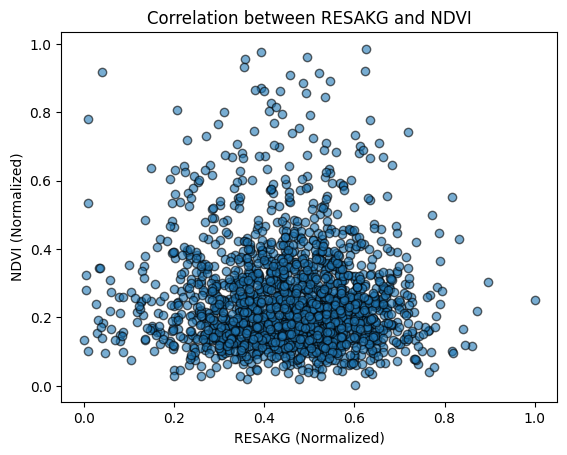

In [25]:
correlation = np.corrcoef(resakg_normalized, ndvi_reshaped)[0, 1]
print("Pearson Correlation Coefficient:", correlation)

from scipy.stats import spearmanr

spearman_corr, _ = spearmanr(resakg_normalized, ndvi_reshaped)
print("Spearman Correlation Coefficient:", spearman_corr)

# Scatter plot
plt.scatter(resakg_normalized, ndvi_reshaped, alpha=0.6, edgecolor='k')
plt.title("Correlation between RESAKG and NDVI")
plt.xlabel("RESAKG (Normalized)")
plt.ylabel("NDVI (Normalized)")
plt.show()


### Scatter Plot Analysis

The scatter plot reveals:
- A dense cluster of points concentrated in the mid-range (0.4-0.6) of RESAKG values
- Moderate dispersion of NDVI values (0.1-0.4) for this central cluster
- Some outliers present at both high and low ends of both variables
- No clear strong linear relationship between variables, suggesting a weak to moderate correlation
- The pattern appears somewhat diffuse, indicating there might be other factors influencing the relationship between RESAKG and NDVI